# WBGT in observations (ISIMIP3a): shift fit development 

Test from Obsclim

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, (statsmodels?)

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings import *

# import fxns 
from functions import *
from utils import *
from plotscript import *

# import other packages/modules 

sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! --> change to import demographics4climate as d4c


/apps/brussel/CO7/broadwell/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
from scipy import stats
import seaborn as sns

import corner
import dist_cov # env = myenv where i installed dist_cov

In [3]:
start_message() # change indir to indir obs and datasets to datasets obs in start message

flags: {'models': 'ISIMIP3a', 'experiment': 'counterclim', 'metric': 'WBGT', 'method': 'calculate', 'time_method': None, 'chunk_version': 2}
var: None
VARs: ['tasmax', 'huss', 'ps']
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
datasets: ['GSWP3-W5E5', '20CRv3', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
time_chunk: -1
outdirs: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output
figdirs: /data/brussel/vo/

In [4]:
#from dask.distributed import Client 
#client = Client()
#client

In [5]:
figdir = os.path.join(figdirs, 'fig_apr24-isimip3a-wbgt')
flags['models'] = 'ISIMIP3a'
GCM=datasets[0]

## Open data: one pixel for Delhi and one pixel for Calcutta

In [6]:
variable='wbgt'
dirname='output_apr24-9139513' #'output_apr24-9110516' - put them in same folder!
dir1=os.path.join(scratchdirs, dirname, 'WBGT', flags['models'], 'obsclim', GCM ) # if you always change flags metric you can also replace with fxn 
filepaths=get_filepaths(variable.upper(),dir1)
lat, lon = 28,77

In [7]:
filepaths

['/scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_apr24-9139513/WBGT/ISIMIP3a/obsclim/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_1901_1910.nc',
 '/scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_apr24-9139513/WBGT/ISIMIP3a/obsclim/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_1911_1920.nc',
 '/scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_apr24-9139513/WBGT/ISIMIP3a/obsclim/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_1921_1930.nc',
 '/scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_apr24-9139513/WBGT/ISIMIP3a/obsclim/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_1931_1940.nc',
 '/scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_apr24-9139513/WBGT/ISIMIP3a/obsclim/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_1941_1950.nc',
 '/scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_apr24-9139513/WBGT/ISIMIP3a/obsclim/GSWP3-W5E5/gswp3-w5e5_obsclim_WBGT_1951_1960.nc',
 '/scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_apr24-9139513/WBGT/ISI

In [8]:
with xr.open_mfdataset(filepaths, engine='netcdf4') as ds:
    da_delhi = ds[str(variable)].sel(lat=lat, lon=lon, method='nearest').chunk({'time': -1}).compute()
    da_calcutta = ds[str(variable)].sel(lat=22, lon=88, method='nearest').chunk({'time': -1}).compute()

In [9]:
da_delhi 

<xarray.DataArray 'wbgt' (time: 43464)>
array([16.66319 , 16.832773, 16.74808 , ..., 13.003847, 11.634802,
       12.386272], dtype=float32)
Coordinates:
    lon      float32 77.25
    lat      float32 28.25
  * time     (time) datetime64[ns] 1901-01-01 1901-01-02 ... 2019-12-31

## Plot timeseries: Delhi and Calcutta

There is clear seasonality. There is also a clear discontinuity between the 2 merged datasets (in Delhi only)

Ideas:
- correct for discontinuity of variance??? will change frequency of threshold exceedance, is why you get reduction of WBGT exceedance for some thresholds/very hot days
- use only recent dataset from 70s ? 
- use only era5 whole time? 
- way to detect pixels where there is clear discontinuity in variance 

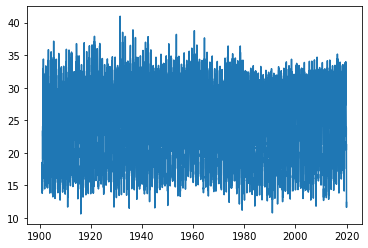

In [10]:
plt.plot(da_delhi.time, da_delhi.values)



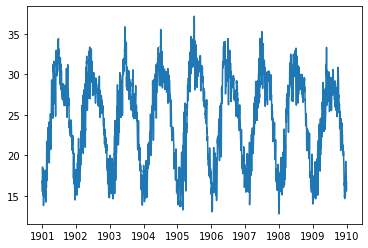

In [11]:
plt.plot(da_delhi.sel(time=slice('1901-01-01', '1910-01-01')).time, da_delhi.sel(time=slice('1901-01-01', '1910-01-01')).values)

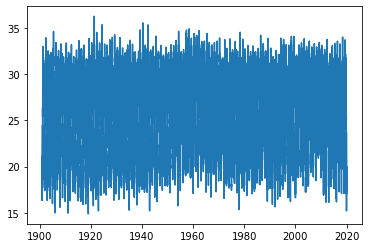

In [12]:
plt.plot(da_calcutta.time, da_calcutta.values)


## Plot distributions: Calcutta and Delhi

Distributions clearly multimodal due to seasonality

Text(0.5, 1.0, 'Delhi 1901-1930 v. 1990-2020')

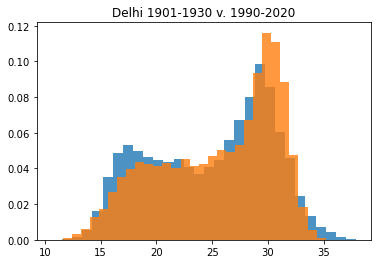

In [13]:
plt.hist(da_delhi.sel(time=slice('1901-01-01', '1931-01-01')), bins=30, alpha=0.8, density=True);

plt.hist(da_delhi.sel(time=slice('1990-01-01', '2020-01-01')),bins=30, alpha=0.8, density=True);

plt.title('Delhi 1901-1930 v. 1990-2020')

Text(0.5, 1.0, 'Calcutta 1901-1930 v. 1990-2020')

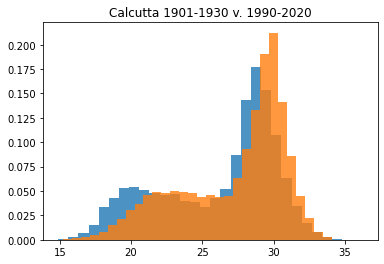

In [14]:
plt.hist(da_calcutta.sel(time=slice('1901-01-01', '1931-01-01')), bins=30, alpha=0.8, density=True);

plt.hist(da_calcutta.sel(time=slice('1990-01-01', '2020-01-01')),bins=30, alpha=0.8, density=True);

plt.title('Calcutta 1901-1930 v. 1990-2020')

## Plot seasonal cycle 

Text(0.5, 1.0, 'Mean daily seasonal cycle 1990-2020')

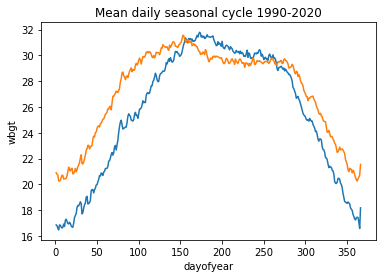

In [15]:
da_delhi_mean = da_delhi.sel(time=slice('1990-01-01', '2020-01-01')).groupby("time.dayofyear").mean("time")
da_calcutta_mean = da_calcutta.sel(time=slice('1990-01-01', '2020-01-01')).groupby("time.dayofyear").mean("time")

fig, ax = plt.subplots()
da_delhi_mean.plot(ax=ax, label='delhi')
da_calcutta_mean.plot(ax=ax, label='calcutta')

plt.title('Mean daily seasonal cycle 1990-2020')

Text(0.5, 1.0, 'Mean monthly seasonal cycle 1990-2020 vs. 1901-1931')

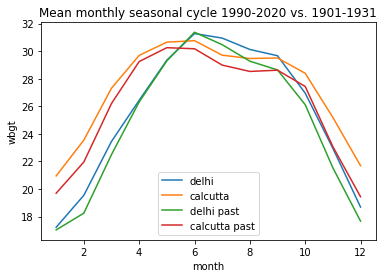

In [16]:
da_delhi_mean_mo = da_delhi.sel(time=slice('1990-01-01', '2020-01-01')).groupby("time.month").mean("time")
da_calcutta_mean_mo = da_calcutta.sel(time=slice('1990-01-01', '2020-01-01')).groupby("time.month").mean("time")

da_delhi_mean_mo_old = da_delhi.sel(time=slice('1901-01-01', '1931-01-01')).groupby("time.month").mean("time")
da_calcutta_mean_mo_old = da_calcutta.sel(time=slice('1901-01-01', '1931-01-01')).groupby("time.month").mean("time")

fig, ax = plt.subplots()
da_delhi_mean_mo.plot(ax=ax, label='delhi')
da_calcutta_mean_mo.plot(ax=ax, label='calcutta')

da_delhi_mean_mo_old.plot(ax=ax, label='delhi past')
da_calcutta_mean_mo_old.plot(ax=ax, label='calcutta past')

plt.legend()

plt.title('Mean monthly seasonal cycle 1990-2020 vs. 1901-1931')

## Split and look at distributions by seasons

Splitting into seasons improves the unimodality of distributions, in particular for the hot seasons, less so for colder seasons where there is a lot of spread (transition seasons). 

In [17]:
def find_warmest_months(da, window):
    # Step 1: Calculate monthly mean temperatures
    monthly_means = da.groupby('time.month').mean('time')

    # Step 2: Create a sliding window of six months
    # Since months are cyclic, we need to concatenate the data to handle the wrap-around
    extended_monthly_means = xr.concat([monthly_means, monthly_means], dim='month')

    # Step 3: Calculate the mean temperature for each window
    # Using a rolling window of 6 months
    rolling_means = extended_monthly_means.rolling(month=window, center=False).mean()

    # Since the rolling mean will have NaN values at the start, we shift to get valid means
    rolling_means = rolling_means.dropna('month')

    # Step 4: Identify the windows with the highest and lowest mean temperature
    # Since we duplicated the months, we need to only consider the first 12 rolling means
    valid_rolling_means = rolling_means.isel(month=slice(0, 12))

    warmest_start_month = valid_rolling_means.argmax('month').item()
    coldest_start_month = valid_rolling_means.argmin('month').item()

    # Determine the corresponding months
    warmest_months = [(warmest_start_month + i) % 12 + 1 for i in range(window)]
    #coldest_months = [(coldest_start_month + i) % 12 + 1 for i in range(6)]

    #print(f"Warmest 6-month period starts in month: {warmest_start_month + 1} (months: {warmest_months})")
    #print(f"Coldest 6-month period starts in month: {coldest_start_month + 1} (months: {coldest_months})")
    
    return warmest_months
    

### warmest and coldest 6 month periods

In [18]:
windowsize=6

da = da_delhi.sel(time=slice('1990-01-01', '2020-01-01'))

da_delhi_summer = da.sel(time=da['time.month'].isin(find_warmest_months(da, window=windowsize)))
da_delhi_winter = da.sel(time=~da['time.month'].isin(find_warmest_months(da, window=windowsize)))

print(find_warmest_months(da, window=windowsize))


da = da_calcutta.sel(time=slice('1990-01-01', '2020-01-01'))

da_calcutta_summer = da.sel(time=da['time.month'].isin(find_warmest_months(da, window=windowsize)))
da_calcutta_winter = da.sel(time=~da['time.month'].isin(find_warmest_months(da, window=windowsize)))

print(find_warmest_months(da, window=windowsize))


[5, 6, 7, 8, 9, 10]
[4, 5, 6, 7, 8, 9]


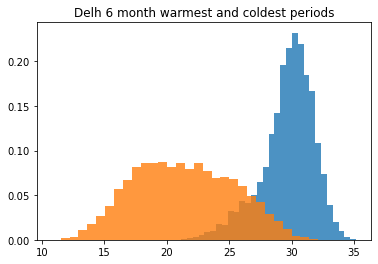

In [19]:
plt.hist(da_delhi_summer, bins=30, alpha=0.8, density=True);
plt.hist(da_delhi_winter, bins=30, alpha=0.8, density=True);

plt.title('Delh 6 month warmest and coldest periods');

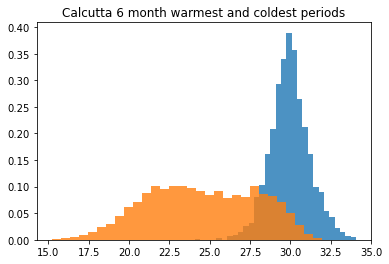

In [20]:
plt.hist(da_calcutta_summer, bins=30, alpha=0.8, density=True);
plt.hist(da_calcutta_winter, bins=30, alpha=0.8, density=True);

plt.title('Calcutta 6 month warmest and coldest periods');

### 3 month periods

Splitting into seasons improves the unimodality of distributions, in particular for the hot seasons, less so for colder seasons where there is a lot of spread (transition seasons). 

There is still a lot of spread/variability within the seasons


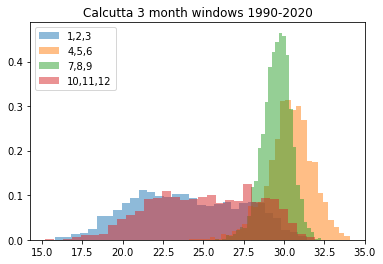

In [57]:
plt.hist(da_calcutta_winter.sel(time=da_calcutta_winter['time.month'].isin([1,2,3])), bins=30, alpha=0.5, density=True, label='1,2,3');
plt.hist(da_calcutta_summer.sel(time=da_calcutta_summer['time.month'].isin([4,5,6])), bins=30, alpha=0.5, density=True, label='4,5,6');
plt.hist(da_calcutta_summer.sel(time=da_calcutta_summer['time.month'].isin([7,8,9])), bins=30, alpha=0.5, density=True, label='7,8,9');
plt.hist(da_calcutta_winter.sel(time=da_calcutta_winter['time.month'].isin([10,11,12])), bins=30, alpha=0.5, density=True, label='10,11,12');

plt.legend()

plt.title('Calcutta 3 month windows 1990-2020');

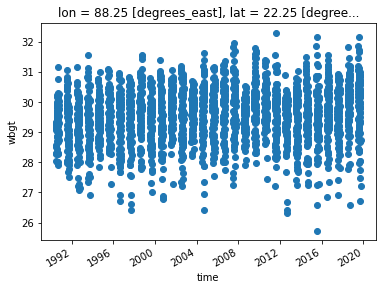

In [22]:
da_calcutta_summer.sel(time=da_calcutta_summer['time.month'].isin([7,8,9])).plot(marker='o', ls='')

### one per month? 

Just assume each month is normally distributed? 

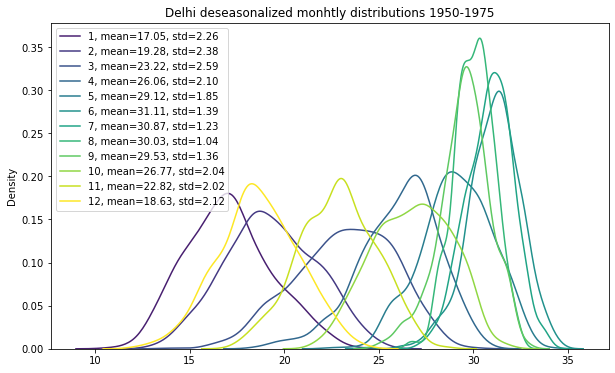

In [209]:
startyear=1990
endyear=2020

fig = plt.figure(figsize=(10,6))

da = da_delhi.sel(time=slice(f'{startyear}-01-01', f'{startyear+win}-01-01'))

# Create a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, 13))


for i in range(13):
    data_plot=da.sel(time=da['time.month'].isin([i]))
    sns.kdeplot(data_plot, label=f'{i}, mean={data_plot.mean():.2f}, std={data_plot.std():.2f}', color=colors[i]);

plt.legend()

plt.title('Delhi not deseasonalized monhtly distributions 1950-1975');

### per day of year (like ATTRICI)

Indeed distributions are more normal in this way, but sample size shrinks a lot. But this could be ok, you have one value per year which is how extreme value distribution (but also normal shift fit on multi month values) are treated in EV attribution. 

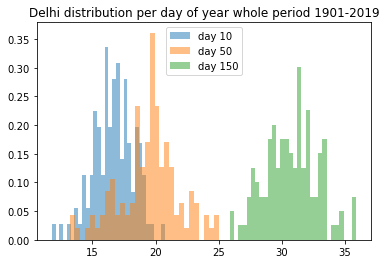

In [23]:
# plot one day of year 

plt.hist(da_delhi.sel(time=da_delhi['time.dayofyear'].isin([10])), bins=30, density=True, alpha=0.5, label='day 10');

plt.hist(da_delhi.sel(time=da_delhi['time.dayofyear'].isin([50])), bins=30, density=True, alpha=0.5, label='day 50');

plt.hist(da_delhi.sel(time=da_delhi['time.dayofyear'].isin([150])), bins=30, density=True, alpha=0.5, label='day 150');

plt.legend();
plt.title('Delhi distribution per day of year whole period 1901-2019');

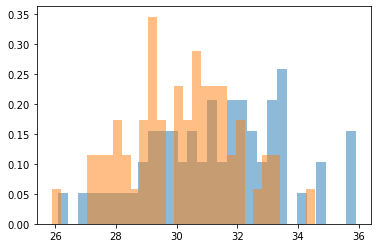

In [24]:
plt.hist(da_delhi.sel(time=da_delhi['time.dayofyear'].isin([150])).sel(time=slice('1900-01-01', '1960-01-01')), bins=30, density=True, alpha=0.5, label='day 150');

plt.hist(da_delhi.sel(time=da_delhi['time.dayofyear'].isin([150])).sel(time=slice('1960-01-01', '2020-01-01')), bins=30, density=True, alpha=0.5, label='day 150');


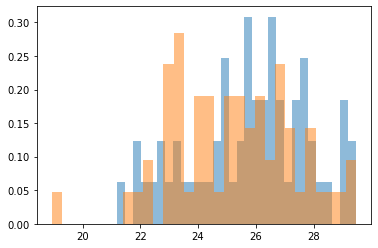

In [25]:
plt.hist(da_delhi.sel(time=da_delhi['time.dayofyear'].isin([100])).sel(time=slice('1900-01-01', '1960-01-01')), bins=30, density=True, alpha=0.5, label='day 150');

plt.hist(da_delhi.sel(time=da_delhi['time.dayofyear'].isin([100])).sel(time=slice('1960-01-01', '2020-01-01')), bins=30, density=True, alpha=0.5, label='day 150');


## ideas

**a) could remove seasonal cycle, then calculate shift ? do I then add seasonal cycle again?**
- try this, and use distcov
- output m0, m1 per grid cell (and seasonality function save this)

**b) could do like attrici, shift distribution of each day of year and then calc p1-p0 for each day of year for relevant threshold, and sum over whole year to get total nAHD that year**
- talk to matthias about this
- output mu0, mu1 instead of variable_cf per grid cell and day of year

**Issues to keep in mind**
- discontinuity between datasets, artificial signals possible. 

# option 1. fit sinusoidal to remove seasonal cycle - NOT FOR NOW

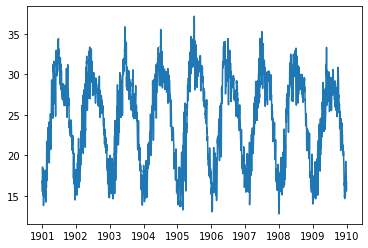

In [26]:
plt.plot(da_delhi.sel(time=slice('1901-01-01', '1910-01-01')).time, da_delhi.sel(time=slice('1901-01-01', '1910-01-01')).values)

In [27]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()


x= np.arange( len(da_delhi.sel(time=slice('1901-01-01', '1910-01-01')).values) ) # your y values list 
y = da_delhi.sel(time=slice('1901-01-01', '1910-01-01')).values # your x values list
X = np.column_stack((np.sin(x), np.cos(x)))

reg.fit(X, y)

a = reg.intercept_
b = reg.coef_[0]
c = reg.coef_[1]

In [28]:
a,b,c

#y=a+b*sin(x)+c*sin(x)



(24.574988347138653, -0.0015992094157547538, -0.001240912361723044)

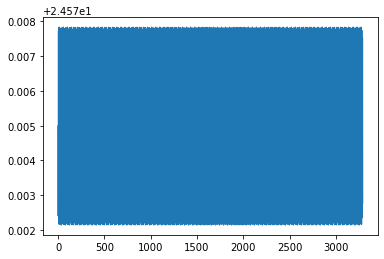

In [29]:
plt.plot(x, a+b*np.sin(x)+c*np.sin(x))

# TO FIX !! 

# option 2. remove emprical seasonal cycle - TESTING

Text(0.5, 1.0, 'Mean climatology 1961-1990 (window 15 days)')

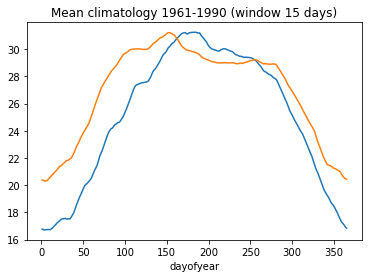

In [30]:
# set baseline for climatology note that this includes pre and post merging datasets
startyear = 1961
endyear = 1990
# windowsize for smoothing 
windowsize=15

# drop Feb 29th leap years? 

# select baseline period, make dataset circular, calculate rolling mean and remove extra dates and start and end 
df = da_delhi.convert_calendar('noleap').sel(time=slice(f'{startyear}-01-01', f'{endyear}-01-01')).groupby("time.dayofyear").mean("time").to_pandas()
da_delhi_climato_empirical = pd.concat([ df.tail(windowsize), df, df.head(windowsize)]).rolling(windowsize,center=True).mean().iloc[windowsize:-windowsize]

df = da_calcutta.convert_calendar('noleap').sel(time=slice(f'{startyear}-01-01', f'{endyear}-01-01')).groupby("time.dayofyear").mean("time").to_pandas()
da_calcutta_climato_empirical = pd.concat([ df.tail(windowsize), df, df.head(windowsize)]).rolling(windowsize,center=True).mean().iloc[windowsize:-windowsize]

fig, ax = plt.subplots()
da_delhi_climato_empirical.plot(ax=ax, label='delhi')
da_calcutta_climato_empirical.plot(ax=ax, label='calcutta')

plt.title(f'Mean climatology {startyear}-{endyear} (window {windowsize} days)')

In [31]:
da_calcutta_climato_empirical

dayofyear
1      20.389165
2      20.365372
3      20.338379
4      20.309591
5      20.298089
         ...    
361    20.628985
362    20.547010
363    20.501272
364    20.476902
365    20.431201
Length: 365, dtype: float64

In [32]:

# Align the climatology to match each day of the year in da_delhi_noleap
climatology_matched = da_delhi_climato_empirical[da_delhi.convert_calendar('noleap')['time'].dt.dayofyear]

# Subtract the climatology from da_delhi to deseasonalize
da_delhi_deseason = da_delhi.convert_calendar('noleap') - climatology_matched
da_delhi_deseason

<xarray.DataArray (time: 43435)>
array([-0.11571922,  0.08651276,  0.03333244, ..., -3.99515419,
       -5.26427066, -4.45523059])
Coordinates:
    lon      float32 77.25
    lat      float32 28.25
  * time     (time) object 1901-01-01 00:00:00 ... 2019-12-31 00:00:00

In [43]:
# Align the climatology to match each day of the year in da_delhi_noleap
climatology_matched = da_calcutta_climato_empirical[da_calcutta.convert_calendar('noleap')['time'].dt.dayofyear]

# Subtract the climatology from da_delhi to deseasonalize
da_calcutta_deseason = da_calcutta.convert_calendar('noleap') - climatology_matched
da_calcutta_deseason

<xarray.DataArray (time: 43435)>
array([-3.35275014, -3.81277453, -3.96585096, ..., -2.51367938,
       -2.57621765, -1.78780696])
Coordinates:
    lon      float32 88.25
    lat      float32 22.25
  * time     (time) object 1901-01-01 00:00:00 ... 2019-12-31 00:00:00

## check results for delhi

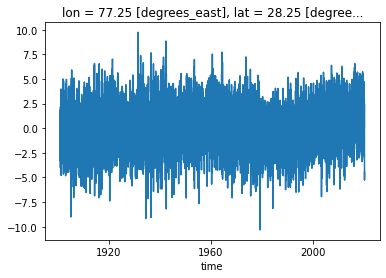

In [34]:
da_delhi_deseason.plot()

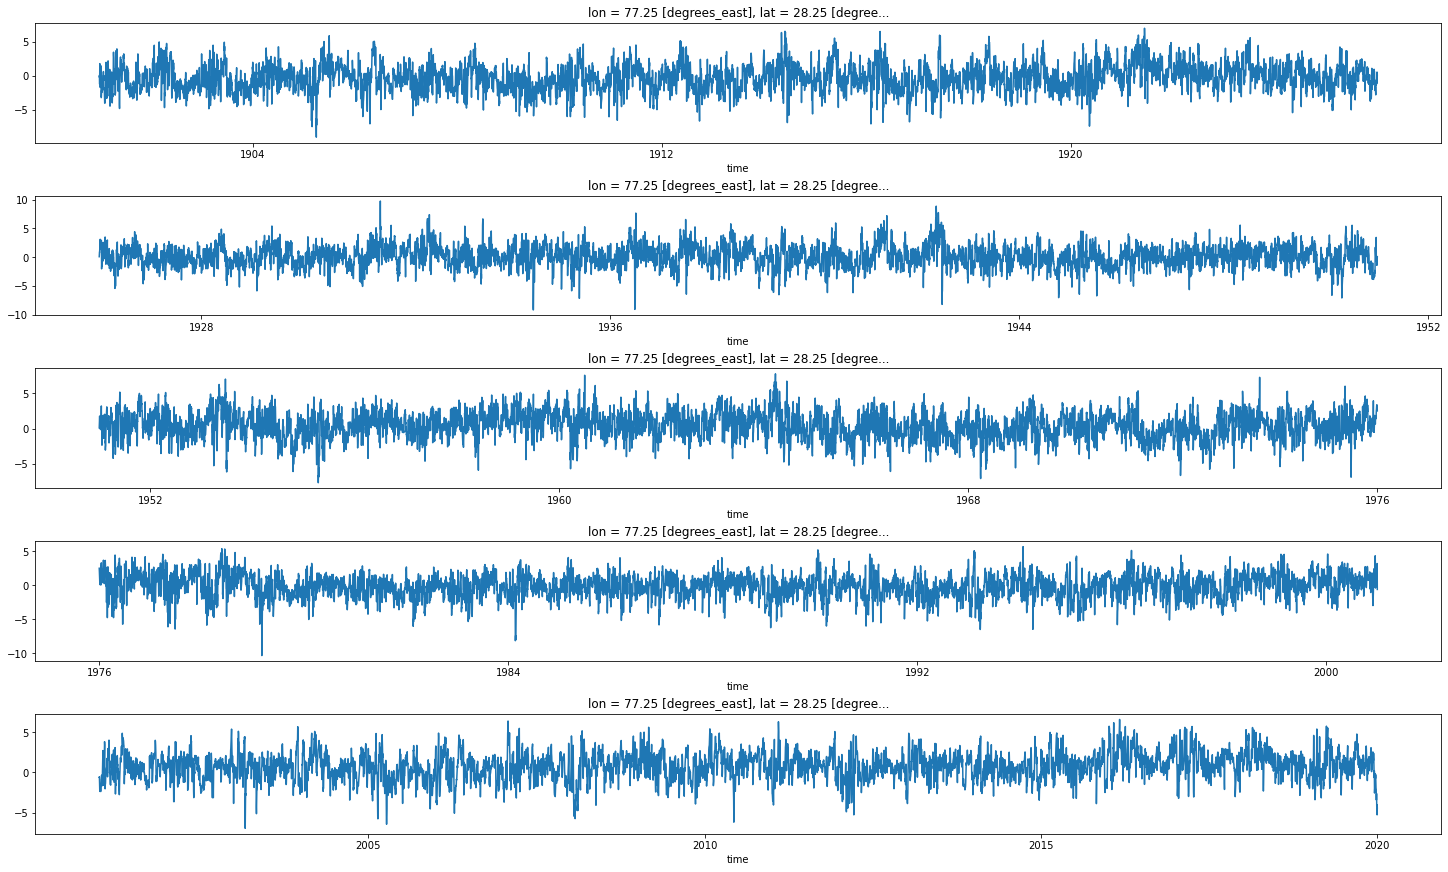

In [35]:
fig, axes = plt.subplots(5,1,figsize=(20,12), layout='constrained')
startyear = 1901 
win=25

for i, ax in enumerate(axes):
    da_delhi_deseason.sel(time=slice(f'{startyear}-01-01', f'{startyear+win}-01-01')).plot(ax=ax);
    startyear+=win

    # after deseasonalising 

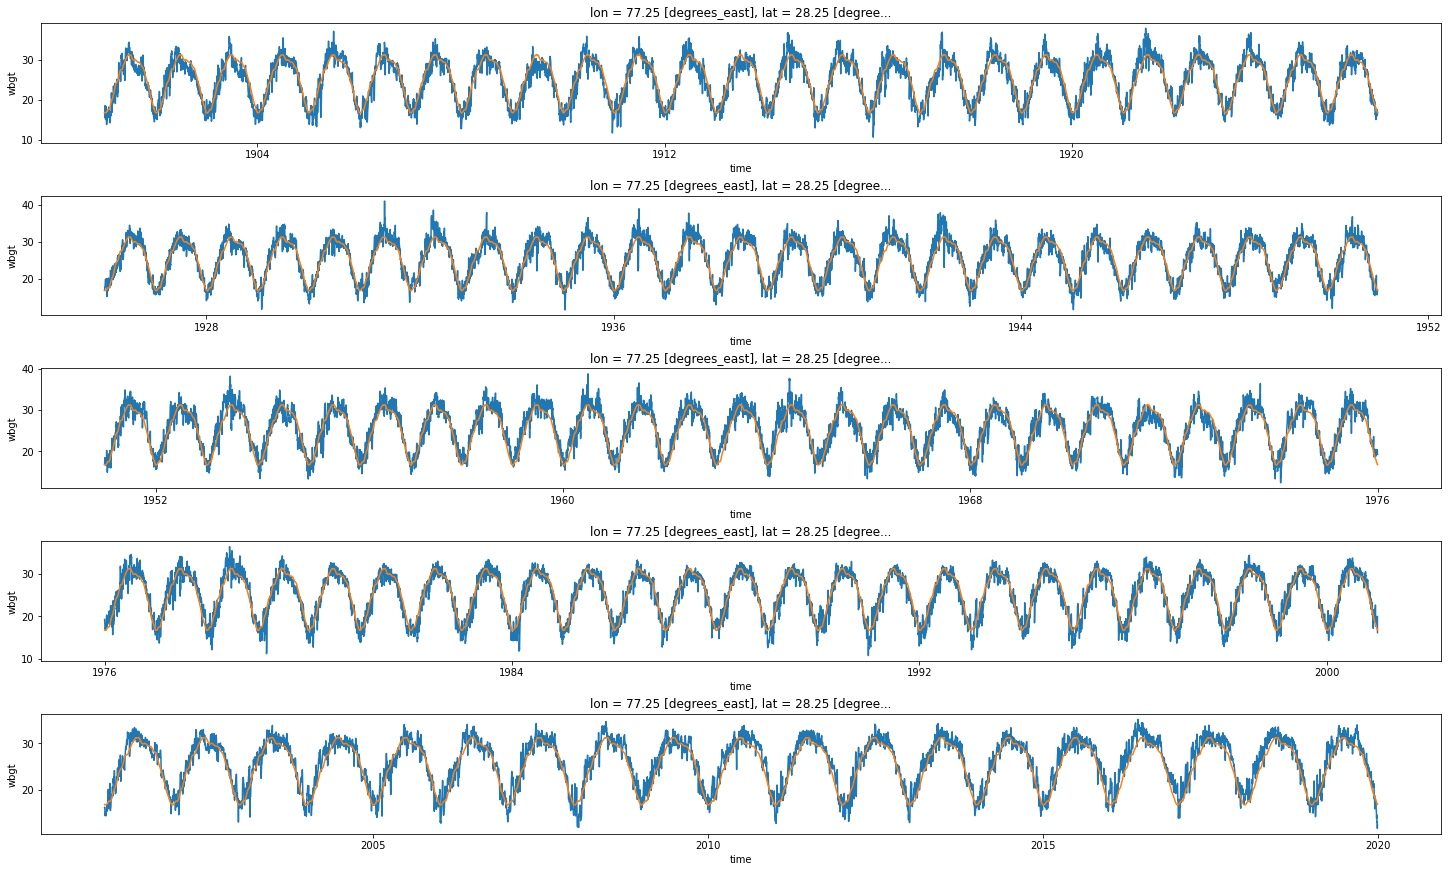

In [36]:
fig, axes = plt.subplots(5,1,figsize=(20,12), layout='constrained')
startyear = 1901 
win=25

for i, ax in enumerate(axes):
    da_sel = da_delhi.convert_calendar('noleap').sel(time=slice(f'{startyear}-01-01', f'{startyear+win}-01-01'))
    da_sel.plot(ax=ax);
    ax.plot(da_sel.time, da_delhi_climato_empirical[da_sel.time.dt.dayofyear])
    startyear+=win

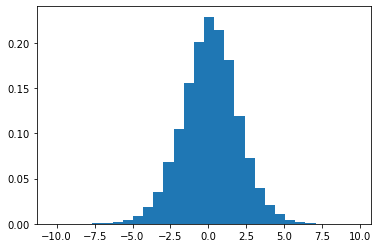

In [38]:
plt.hist(da_delhi_deseason,bins=30,density=True);

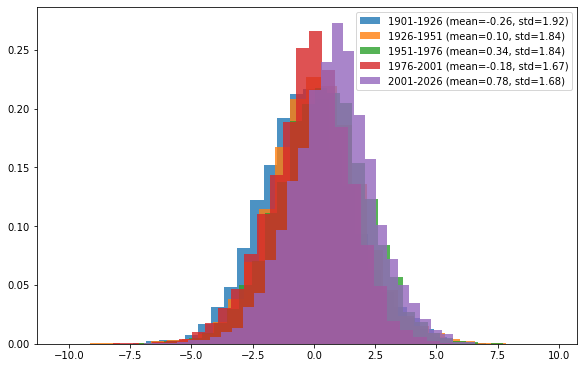

In [39]:
fig, ax = plt.subplots(figsize=(8,5),layout='constrained')
startyear = 1901 
win=25

for i in range(len(np.unique(da_delhi_deseason.time.dt.year)) // win + 1):
    data_plot = da_delhi_deseason.sel(time=slice(f'{startyear}-01-01', f'{startyear+win}-01-01'))
    ax.hist(data_plot, bins=30,density=True, alpha=0.8, label=f'{startyear}-{startyear+win} (mean={data_plot.mean():.2f}, std={data_plot.std():.2f})');
    startyear+=win
    
plt.legend()

In [41]:
da_delhi_deseason.values

array([-0.11571922,  0.08651276,  0.03333244, ..., -3.99515419,
       -5.26427066, -4.45523059])

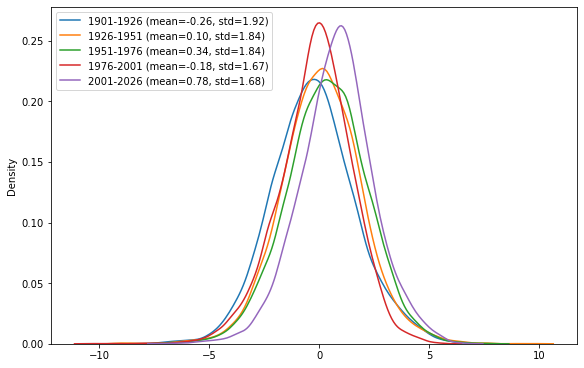

In [42]:
fig, ax = plt.subplots(figsize=(8,5),layout='constrained')
startyear = 1901 
win=25

for i in range(len(np.unique(da_delhi_deseason.time.dt.year)) // win + 1):
    data_plot = da_delhi_deseason.sel(time=slice(f'{startyear}-01-01', f'{startyear+win}-01-01'))
    sns.kdeplot(data_plot.values, label=f'{startyear}-{startyear+win} (mean={data_plot.mean():.2f}, std={data_plot.std():.2f})');
    startyear+=win
    
plt.legend()

# add a predictor variable in the model about what dataset it is ? a dummy variable? 

In [146]:
startyear=1950
win=25

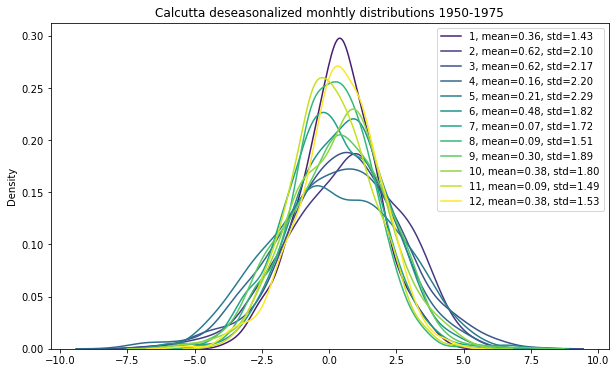

In [147]:

fig = plt.figure(figsize=(10,6))

da = da_delhi_deseason.sel(time=slice(f'{startyear}-01-01', f'{startyear+win}-01-01'))

# Create a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, 13))


for i in range(13):
    data_plot=da.sel(time=da['time.month'].isin([i]))
    sns.kdeplot(data_plot, label=f'{i}, mean={data_plot.mean():.2f}, std={data_plot.std():.2f}', color=colors[i]);

plt.legend()

plt.title('Delhi deseasonalized monhtly distributions 1950-1975');

Text(0, 0.5, 'mean climatology')

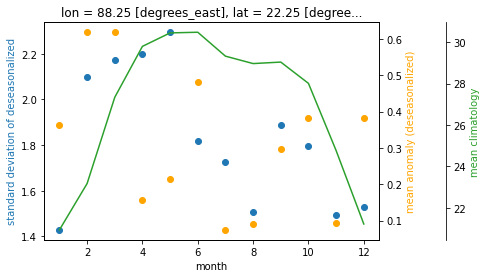

In [148]:
# calculate monthly mean climatolofy in reference years
startyear = 1961
endyear = 1990
da_delhi_mean_mo = da_delhi.sel(time=slice(f'{startyear}-01-01', f'{endyear}-01-01')).groupby("time.month").mean("time")


# plot against std and mean anomaly of deseasonalised in same months
i = np.arange(1,13)

fig, ax = plt.subplots()

ax.scatter(i, da.groupby("time.month").std())
ax.set_ylabel('standard deviation of deseasonalized',color='C0')
plt.xlabel('month')

ax2 = ax.twinx() 
ax2.scatter(i, da.groupby("time.month").mean(), c='orange')
ax2.set_ylabel('mean anomaly (deseasonalized)', color='orange')
#ax2.tick_params(axis='y', labelcolor='orange')

ax3=ax.twinx() 
ax3.spines.right.set_position(("axes", 1.2))
da_calcutta_mean_mo.plot(ax=ax3, c='C2');
ax3.set_ylabel('mean climatology', color='C2')


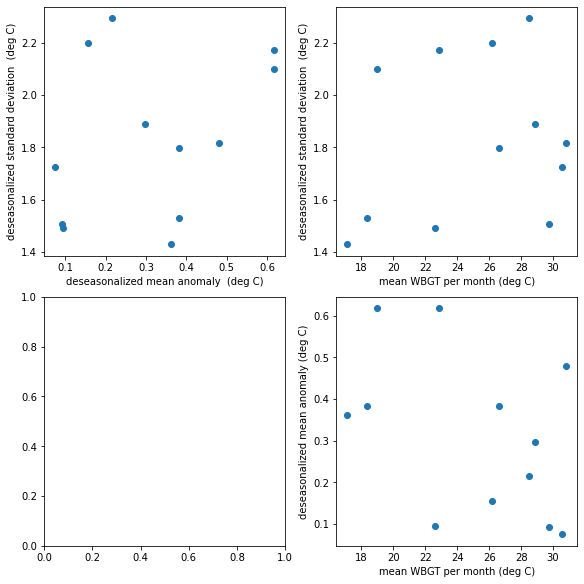

In [149]:
fig, axes = plt.subplots(2,2,figsize=(8,8), layout='constrained')

ax1=axes[0,0]
ax1.scatter(da.groupby("time.month").mean(), da.groupby("time.month").std() )
ax1.set_ylabel('deseasonalized standard deviation  (deg C)')
ax1.set_xlabel('deseasonalized mean anomaly  (deg C)')

ax2=axes[0,1]
ax2.scatter(da_delhi_mean_mo, da.groupby("time.month").std() )
ax2.set_xlabel('mean WBGT per month (deg C)')
ax2.set_ylabel('deseasonalized standard deviation  (deg C)')


ax2=axes[1,1]
ax2.scatter(da_delhi_mean_mo, da.groupby("time.month").mean() )
ax2.set_xlabel('mean WBGT per month (deg C)')
ax2.set_ylabel('deseasonalized mean anomaly (deg C)');


In [151]:
pd.DataFrame(data={'mean':da_delhi_mean_mo.values, 'deseason_anomaly':da.groupby("time.month").mean(), 'deseason_std':da.groupby("time.month").std() }, index=da_delhi_mean_mo.month).corr()

# higher standard deviation in the months in which the average anomaly is higher (r=0.3)
# higher standard deviation in warmer months (weak)


mean  deseason_anomaly  deseason_std
mean              1.000000         -0.444637      0.220643
deseason_anomaly -0.444637          1.000000      0.316759
deseason_std      0.220643          0.316759      1.000000

## check deseasonalized results for calcutta

### is there a clear seasonality or trend left ? 
- there is some seasonality left, but a lot less 
- much more normal! 
- different std in different months/seasons, seems to be higher std in colder months (different in Delhi v. Calcutta, location specific)

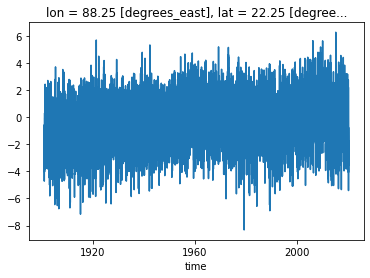

In [44]:
da_calcutta_deseason.plot()

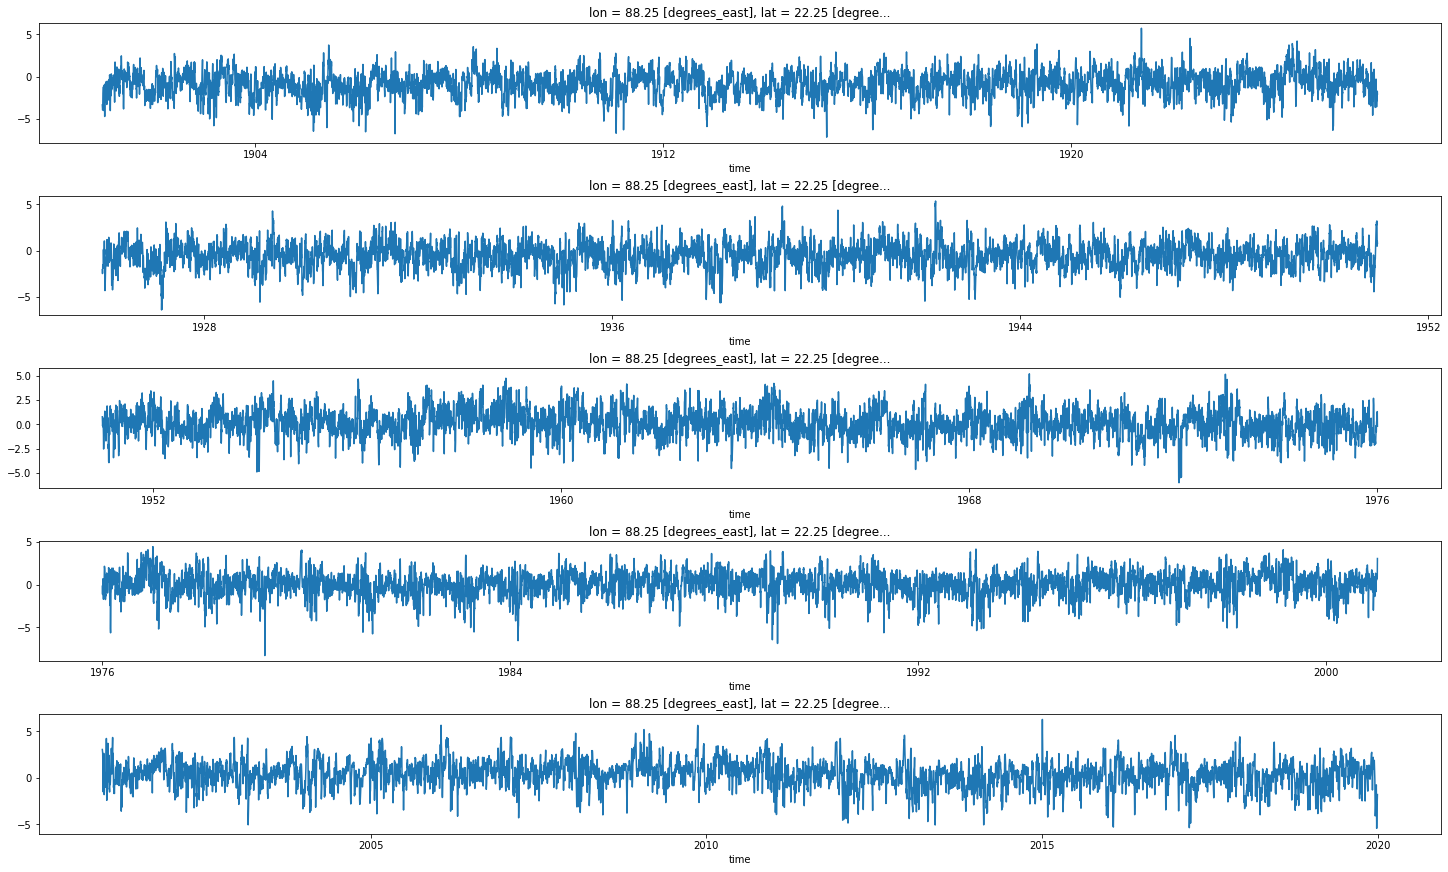

In [45]:
fig, axes = plt.subplots(5,1,figsize=(20,12), layout='constrained')
startyear = 1901 
win=25

for i, ax in enumerate(axes):
    da_calcutta_deseason.sel(time=slice(f'{startyear}-01-01', f'{startyear+win}-01-01')).plot(ax=ax);
    startyear+=win

    # after deseasonalising 

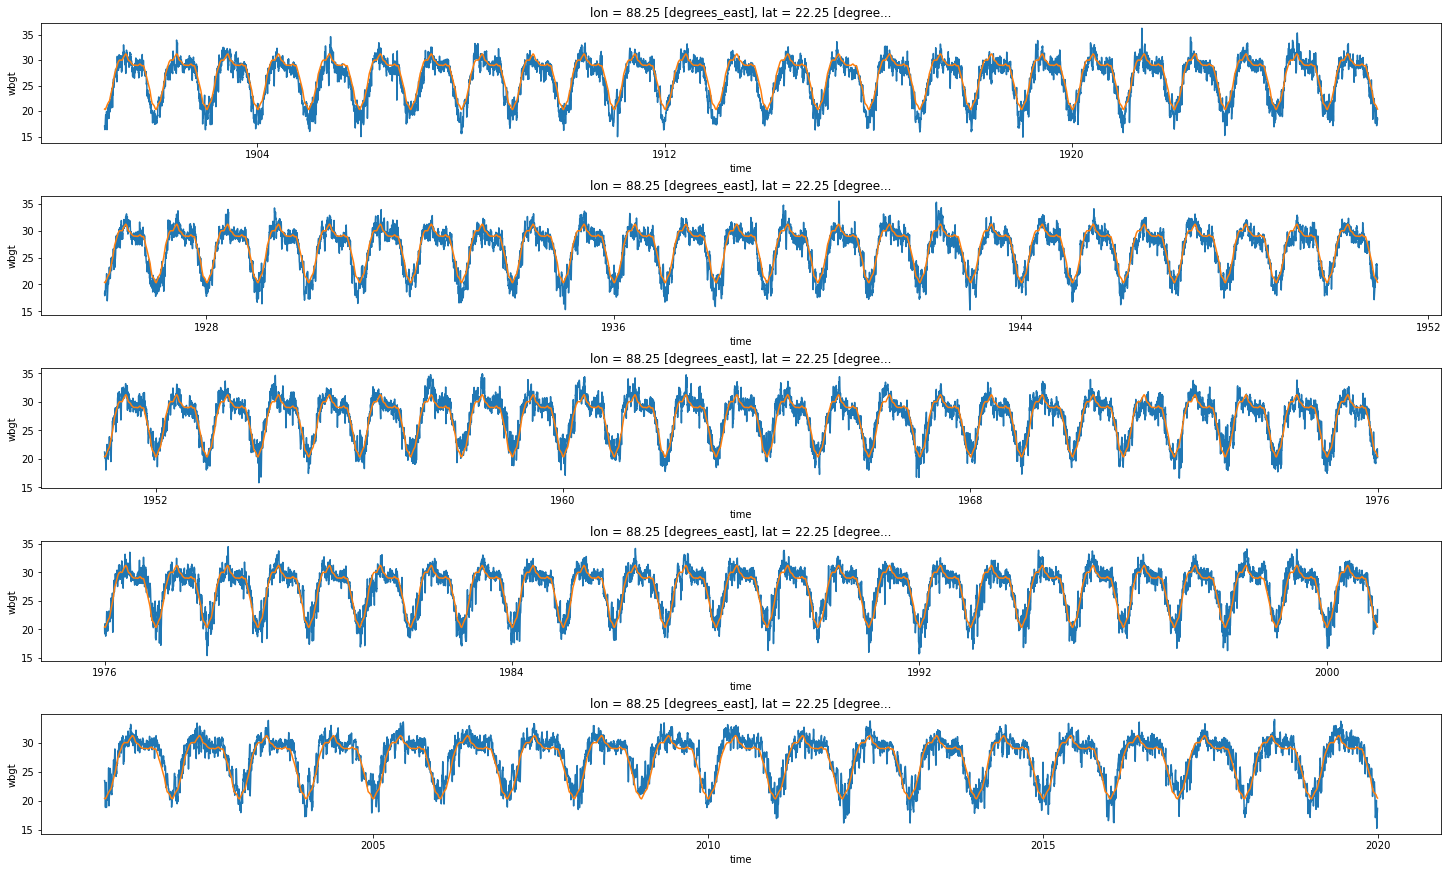

In [46]:
fig, axes = plt.subplots(5,1,figsize=(20,12), layout='constrained')
startyear = 1901 
win=25

for i, ax in enumerate(axes):
    da_sel = da_calcutta.convert_calendar('noleap').sel(time=slice(f'{startyear}-01-01', f'{startyear+win}-01-01'))
    da_sel.plot(ax=ax);
    ax.plot(da_sel.time, da_calcutta_climato_empirical[da_sel.time.dt.dayofyear])
    startyear+=win

distribution much more normal ! 

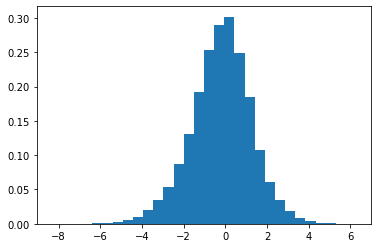

In [47]:
plt.hist(da_calcutta_deseason,bins=30,density=True);

### how is distribution changing?
- shifting to the right and possibly narrowing

ideas
- add a predictor variable in the model about what dataset it is ? a dummy variable? 
- or a term about what month it is, std changing differently in different mnths? 
- or different model per month 

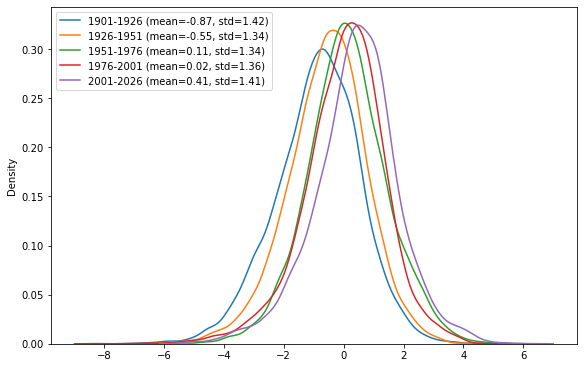

In [49]:
# total distribution shifting in time

fig, ax = plt.subplots(figsize=(8,5),layout='constrained')
startyear = 1901 
win=25

for i in range(len(np.unique(da_delhi_deseason.time.dt.year)) // win + 1):
    data_plot = da_calcutta_deseason.sel(time=slice(f'{startyear}-01-01', f'{startyear+win}-01-01'))
    sns.kdeplot(data_plot.values, label=f'{startyear}-{startyear+win} (mean={data_plot.mean():.2f}, std={data_plot.std():.2f})');
    startyear+=win
    
plt.legend()



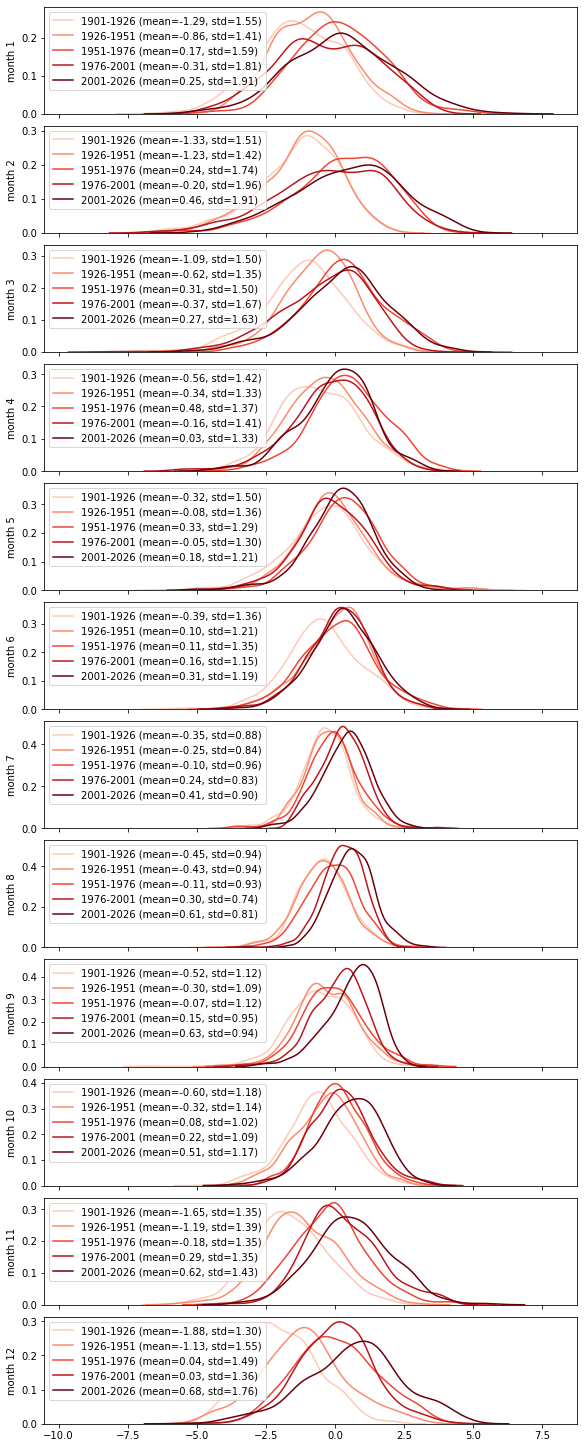

In [179]:
# monthly distribution shifting

fig, axes = plt.subplots(12,1,figsize=(8,20),layout='constrained', sharex=True)

win=25

# Create a colormap
cmap = plt.get_cmap('Reds')
colors = cmap(np.linspace(0, 1, len(np.unique(da_delhi_deseason.time.dt.year)) // win +2))[1:]


# loop over months 
for j in range(1,13):
    startyear = 1901 
    ax=axes[j-1]
    
    
    for i in range(len(np.unique(da_delhi_deseason.time.dt.year)) // win + 1):
        data_plot = da_calcutta_deseason.sel(time=slice(f'{startyear}-01-01', f'{startyear+win}-01-01'))
        data_plot = data_plot.sel(time=data_plot['time.month'].isin([j]))
        sns.kdeplot(data_plot.values, label=f'{startyear}-{startyear+win} (mean={data_plot.mean():.2f}, std={data_plot.std():.2f})', ax=ax, color=colors[i]);
        startyear+=win
    
    ax.legend()
    ax.set_ylabel(f'month {j}')

### are deseasonalized distributions in differnet months differently shaped? Look at data 1950-1975 for example. 
- yes, there are seasonal differences
- higher std in colder months (r = -0.7 approx)

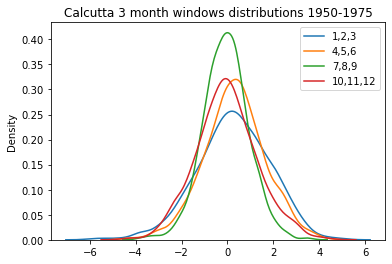

In [145]:
startyear=1950
win=25

da = da_calcutta_deseason.sel(time=slice(f'{startyear}-01-01', f'{startyear+win}-01-01'))

sns.kdeplot(da.sel(time=da['time.month'].isin([1,2,3])), label='1,2,3');
sns.kdeplot(da.sel(time=da['time.month'].isin([4,5,6])), label='4,5,6');
sns.kdeplot(da.sel(time=da['time.month'].isin([7,8,9])), label='7,8,9');
sns.kdeplot(da.sel(time=da['time.month'].isin([10,11,12])), label='10,11,12');

plt.legend()

plt.title('Calcutta 3 month windows distributions 1950-1975');

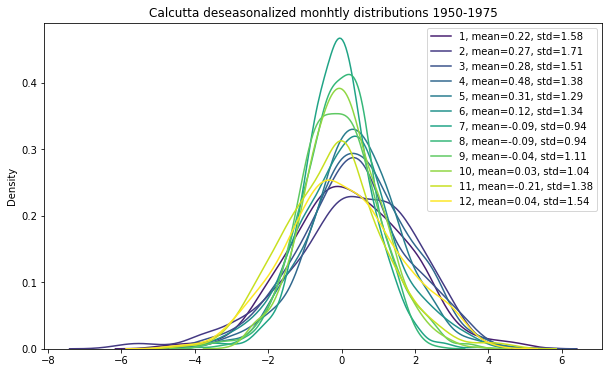

In [144]:

fig = plt.figure(figsize=(10,6))

da = da_calcutta_deseason.sel(time=slice(f'{startyear}-01-01', f'{startyear+win}-01-01'))

# Create a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, 13))


for i in range(13):
    data_plot=da.sel(time=da['time.month'].isin([i]))
    sns.kdeplot(data_plot, label=f'{i}, mean={data_plot.mean():.2f}, std={data_plot.std():.2f}', color=colors[i]);

plt.legend()

plt.title('Calcutta deseasonalized monhtly distributions 1950-1975');

Text(0, 0.5, 'mean climatology')

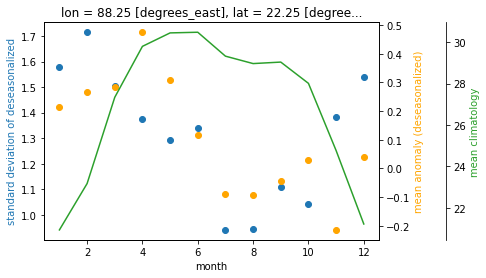

In [105]:
# calculate monthly mean climatolofy in reference years
startyear = 1961
endyear = 1990
da_calcutta_mean_mo = da_calcutta.sel(time=slice(f'{startyear}-01-01', f'{endyear}-01-01')).groupby("time.month").mean("time")


# plot against std and mean anomaly of deseasonalised in same months
i = np.arange(1,13)

fig, ax = plt.subplots()

ax.scatter(i, da.groupby("time.month").std())
ax.set_ylabel('standard deviation of deseasonalized',color='C0')
plt.xlabel('month')

ax2 = ax.twinx() 
ax2.scatter(i, da.groupby("time.month").mean(), c='orange')
ax2.set_ylabel('mean anomaly (deseasonalized)', color='orange')
#ax2.tick_params(axis='y', labelcolor='orange')

ax3=ax.twinx() 
ax3.spines.right.set_position(("axes", 1.2))
da_calcutta_mean_mo.plot(ax=ax3, c='C2');
ax3.set_ylabel('mean climatology', color='C2')


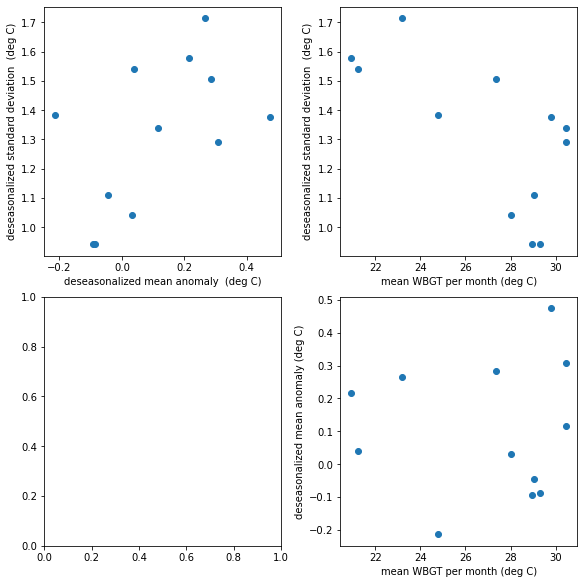

In [133]:
fig, axes = plt.subplots(2,2,figsize=(8,8), layout='constrained')

ax1=axes[0,0]
ax1.scatter(da.groupby("time.month").mean(), da.groupby("time.month").std() )
ax1.set_ylabel('deseasonalized standard deviation  (deg C)')
ax1.set_xlabel('deseasonalized mean anomaly  (deg C)')

ax2=axes[0,1]
ax2.scatter(da_calcutta_mean_mo, da.groupby("time.month").std() )
ax2.set_xlabel('mean WBGT per month (deg C)')
ax2.set_ylabel('deseasonalized standard deviation  (deg C)')


ax2=axes[1,1]
ax2.scatter(da_calcutta_mean_mo, da.groupby("time.month").mean() )
ax2.set_xlabel('mean WBGT per month (deg C)')
ax2.set_ylabel('deseasonalized mean anomaly (deg C)');


In [139]:
pd.DataFrame(data={'mean':da_calcutta_mean_mo.values, 'deseason_anomaly':da.groupby("time.month").mean(), 'deseason_std':da.groupby("time.month").std() }, index=da_calcutta_mean_mo.month).corr()

# higher standard deviation in the months in which the average anomaly is higher (r=0.5)
# higher standard deviation in colder months (r=-0.67)


mean  deseason_anomaly  deseason_std
mean              1.000000          0.054838     -0.670344
deseason_anomaly  0.054838          1.000000      0.531158
deseason_std     -0.670344          0.531158      1.000000

### look at a different period (1990-2015)

Similar pattern to older period. Good thing. 

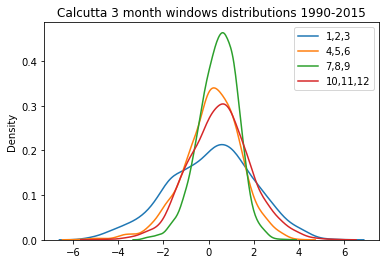

In [181]:
startyear=1990
win=25

da = da_calcutta_deseason.sel(time=slice(f'{startyear}-01-01', f'{startyear+win}-01-01'))

sns.kdeplot(da.sel(time=da['time.month'].isin([1,2,3])), label='1,2,3');
sns.kdeplot(da.sel(time=da['time.month'].isin([4,5,6])), label='4,5,6');
sns.kdeplot(da.sel(time=da['time.month'].isin([7,8,9])), label='7,8,9');
sns.kdeplot(da.sel(time=da['time.month'].isin([10,11,12])), label='10,11,12');

plt.legend()

plt.title(f'Calcutta 3 month windows distributions {startyear}-{startyear+win}');

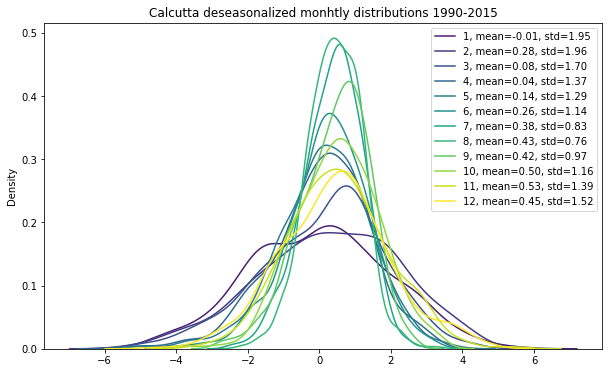

In [182]:

fig = plt.figure(figsize=(10,6))

da = da_calcutta_deseason.sel(time=slice(f'{startyear}-01-01', f'{startyear+win}-01-01'))

# Create a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, 13))


for i in range(13):
    data_plot=da.sel(time=da['time.month'].isin([i]))
    sns.kdeplot(data_plot, label=f'{i}, mean={data_plot.mean():.2f}, std={data_plot.std():.2f}', color=colors[i]);

plt.legend()

plt.title(f'Calcutta deseasonalized monhtly distributions {startyear}-{startyear+win}');

Text(0, 0.5, 'mean climatology')

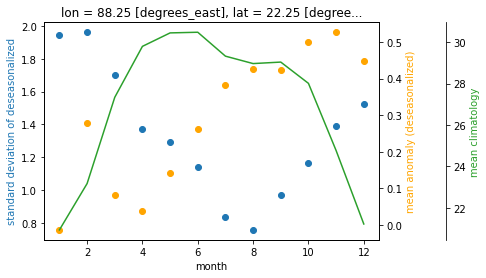

In [155]:
# calculate monthly mean climatolofy in reference years
startyear = 1961
endyear = 1990
da_calcutta_mean_mo = da_calcutta.sel(time=slice(f'{startyear}-01-01', f'{endyear}-01-01')).groupby("time.month").mean("time")


# plot against std and mean anomaly of deseasonalised in same months
i = np.arange(1,13)

fig, ax = plt.subplots()

ax.scatter(i, da.groupby("time.month").std())
ax.set_ylabel('standard deviation of deseasonalized',color='C0')
plt.xlabel('month')

ax2 = ax.twinx() 
ax2.scatter(i, da.groupby("time.month").mean(), c='orange')
ax2.set_ylabel('mean anomaly (deseasonalized)', color='orange')
#ax2.tick_params(axis='y', labelcolor='orange')

ax3=ax.twinx() 
ax3.spines.right.set_position(("axes", 1.2))
da_calcutta_mean_mo.plot(ax=ax3, c='C2');
ax3.set_ylabel('mean climatology', color='C2')


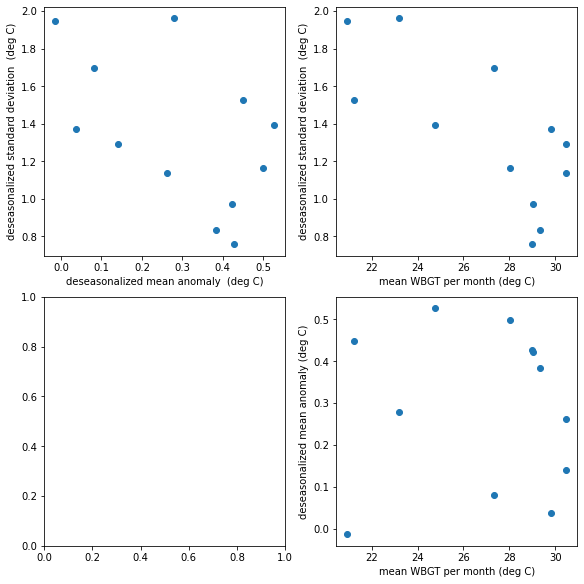

In [156]:
fig, axes = plt.subplots(2,2,figsize=(8,8), layout='constrained')

ax1=axes[0,0]
ax1.scatter(da.groupby("time.month").mean(), da.groupby("time.month").std() )
ax1.set_ylabel('deseasonalized standard deviation  (deg C)')
ax1.set_xlabel('deseasonalized mean anomaly  (deg C)')

ax2=axes[0,1]
ax2.scatter(da_calcutta_mean_mo, da.groupby("time.month").std() )
ax2.set_xlabel('mean WBGT per month (deg C)')
ax2.set_ylabel('deseasonalized standard deviation  (deg C)')


ax2=axes[1,1]
ax2.scatter(da_calcutta_mean_mo, da.groupby("time.month").mean() )
ax2.set_xlabel('mean WBGT per month (deg C)')
ax2.set_ylabel('deseasonalized mean anomaly (deg C)');


In [157]:
pd.DataFrame(data={'mean':da_calcutta_mean_mo.values, 'deseason_anomaly':da.groupby("time.month").mean(), 'deseason_std':da.groupby("time.month").std() }, index=da_calcutta_mean_mo.month).corr()

# higher standard deviation in the months in which the average anomaly is higher (r=0.5)
# higher standard deviation in colder months (r=-0.67)


mean  deseason_anomaly  deseason_std
mean              1.000000          0.002633     -0.727123
deseason_anomaly  0.002633          1.000000     -0.526084
deseason_std     -0.727123         -0.526084      1.000000

# Options/ideas

1) simple and lots of assumptions: single distribution the whole year

- take deasonalized distribution assume it is all from the same normal distribution, and shift varying only the mean or also the std the whole annual distribution
- but then i need to reinsert seasonality and the spread around it, and there is greater spread in colder months so would not be a very good idea to shift whole distribution, I think? 

2) take into account monthly differences

- make a different model for each month? 
- a) don't deseasonalize, get each to shift with mean and std and calculate the percentile of WBGT28 that month. sum over the year to get a value for the year. This would be without deseasonalizing, so data will fit normal a bit less well
- b) otherwise could I deseasonalize, then fit a model per month, then re-insert the base seasonality somehow? just shift by mean climatology that month? Test both ways and see how big the difference is. 
- or c) make a single model and add a categorical/dummy variable with the month of the year??

Try with distcov! Or get Clair to help and try to do in R/r2py

# First try with distcov: against time as a test not gmst - do this with GMST!!!

Covariate value is year so each obs of the same year has the same covariate value

check this is not first performing lin reg and then fitting distribution (cfr with Clair)

In [188]:
x = da_delhi_deseason.values
x

array([-0.11571922,  0.08651276,  0.03333244, ..., -3.99515419,
       -5.26427066, -4.45523059])

In [193]:
t = da_delhi_deseason.time.dt.year - 1900
t

<xarray.DataArray 'year' (time: 43435)>
array([  1,   1,   1, ..., 119, 119, 119])
Coordinates:
    lon      float32 77.25
    lat      float32 28.25
  * time     (time) object 1901-01-01 00:00:00 ... 2019-12-31 00:00:00

In [194]:

dist = dist_cov.distributions.norm_cov(data=x, cov=t)


In [195]:
params_mle = dist.fit()

print(dist.param_names)
print(np.round(params_mle, 3))

['b0', 'b1', 'sigma']
[-0.275  0.007  1.821]


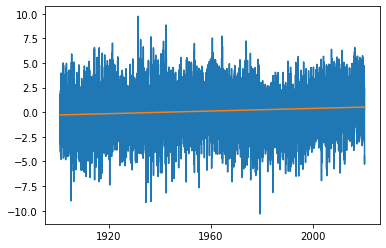

In [197]:
predicted = dist.predict(params_mle, t)

# ===

f, ax = plt.subplots()

ax.plot(da_delhi_deseason.time, x)

ax.plot(da_delhi_deseason.time, predicted)

In [198]:
x = da_calcutta_deseason.values
x

array([-3.35275014, -3.81277453, -3.96585096, ..., -2.51367938,
       -2.57621765, -1.78780696])

In [199]:
t = da_delhi_deseason.time.dt.year - 1900
t

<xarray.DataArray 'year' (time: 43435)>
array([  1,   1,   1, ..., 119, 119, 119])
Coordinates:
    lon      float32 77.25
    lat      float32 28.25
  * time     (time) object 1901-01-01 00:00:00 ... 2019-12-31 00:00:00

In [200]:


dist = dist_cov.distributions.norm_cov(data=x, cov=t)


In [201]:
params_mle = dist.fit()

print(dist.param_names)
print(np.round(params_mle, 3))

['b0', 'b1', 'sigma']
[-0.946  0.012  1.384]


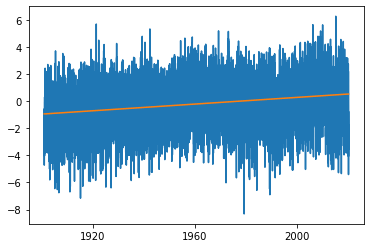

In [202]:
predicted = dist.predict(params_mle, t)

# ===

f, ax = plt.subplots()

ax.plot(da_calcutta_deseason.time, x)

ax.plot(da_calcutta_deseason.time, predicted)

### try different model for different months (on deseasonalised data)

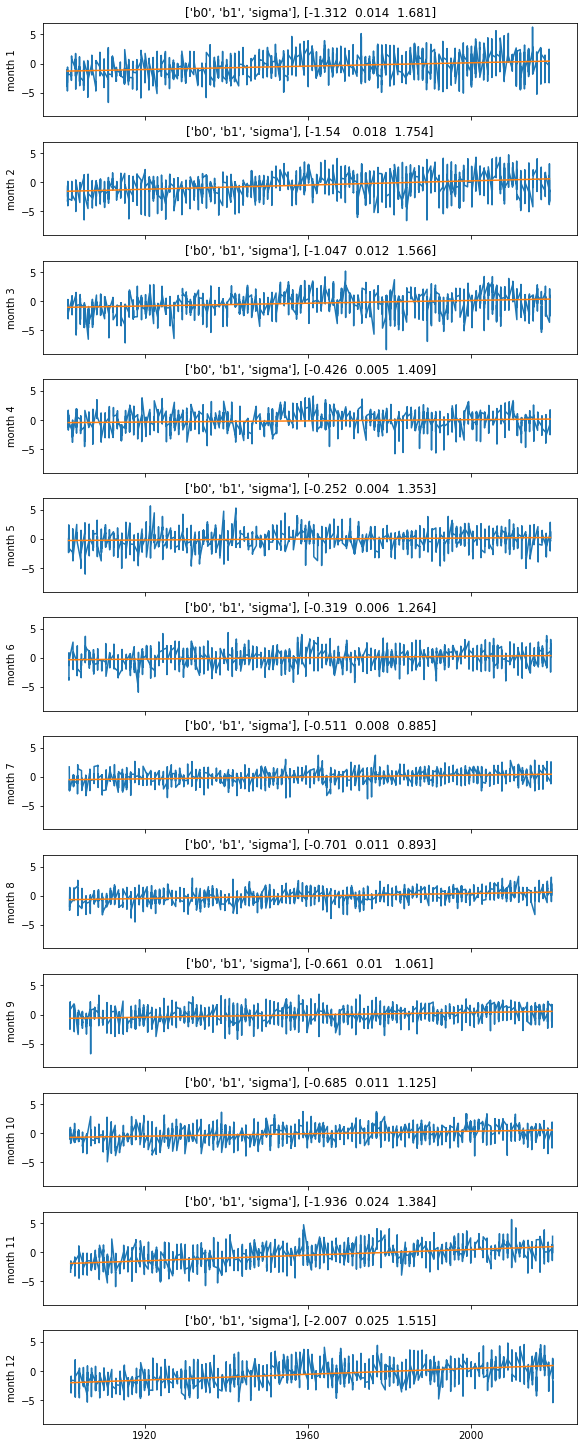

In [208]:
# monthly distribution shifting

fig, axes = plt.subplots(12,1,figsize=(8,20),layout='constrained', sharex=True, sharey=True)


# loop over months 
for j in range(1,13):
    ax=axes[j-1]
    
    da = da_calcutta_deseason.sel(time=da_calcutta_deseason['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year - 1900
    
    dist = dist_cov.distributions.norm_cov(data=x, cov=t)
    params_mle = dist.fit()
    predicted = dist.predict(params_mle, t)

    ax.plot(da.time, x)
    ax.plot(da.time, predicted)
    
    ax.set_title(f'{dist.param_names}, {np.round(params_mle, 3)}')
    ax.set_ylabel(f'month {j}')

## on not deseasonalised data assume each month is normal

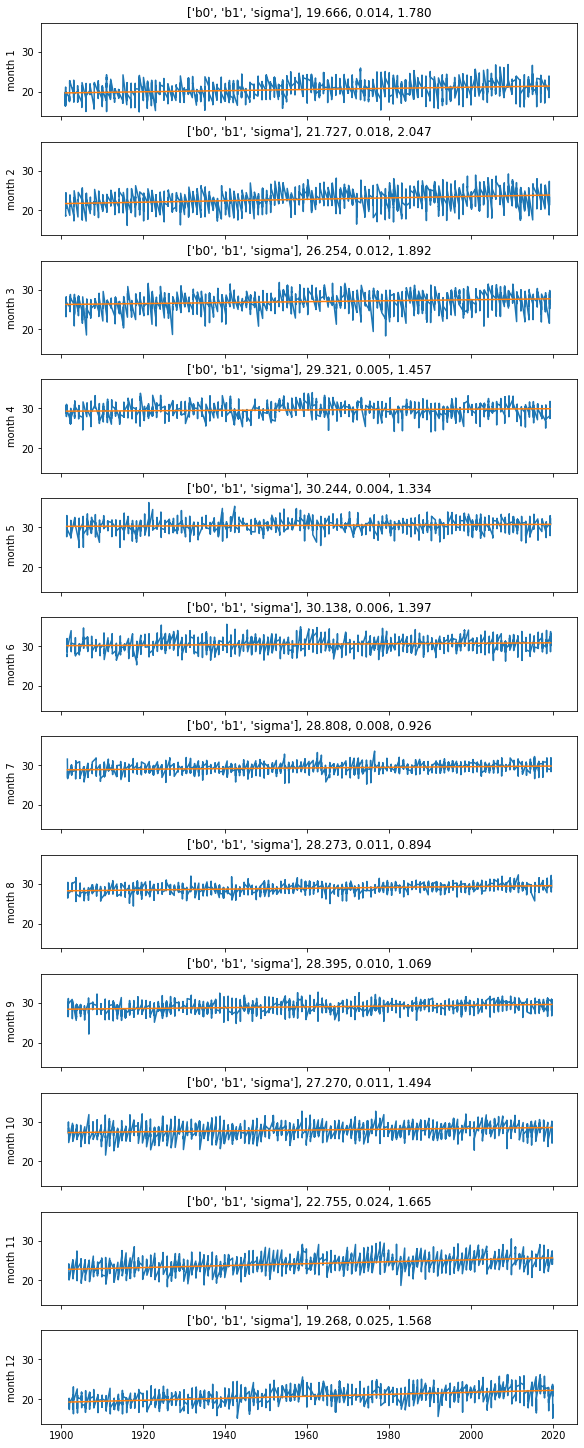

In [216]:
# monthly distribution shifting

fig, axes = plt.subplots(12,1,figsize=(8,20),layout='constrained', sharex=True, sharey=True)


# loop over months 
for j in range(1,13):
    ax=axes[j-1]
    
    da = da_calcutta.sel(time=da_calcutta['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year - 1900
    
    dist = dist_cov.distributions.norm_cov(data=x, cov=t)
    params_mle = dist.fit()
    predicted = dist.predict(params_mle, t)

    ax.plot(da.time, x)
    ax.plot(da.time, predicted)
    
    #ax.set_title(f'{dist.param_names}, {np.round(params_mle, 3)}')
    formatted_params = ', '.join([f'{param:.3f}' for param in params_mle])
    ax.set_title(f'{dist.param_names}, {formatted_params}')

    ax.set_ylabel(f'month {j}')

### try on delhi

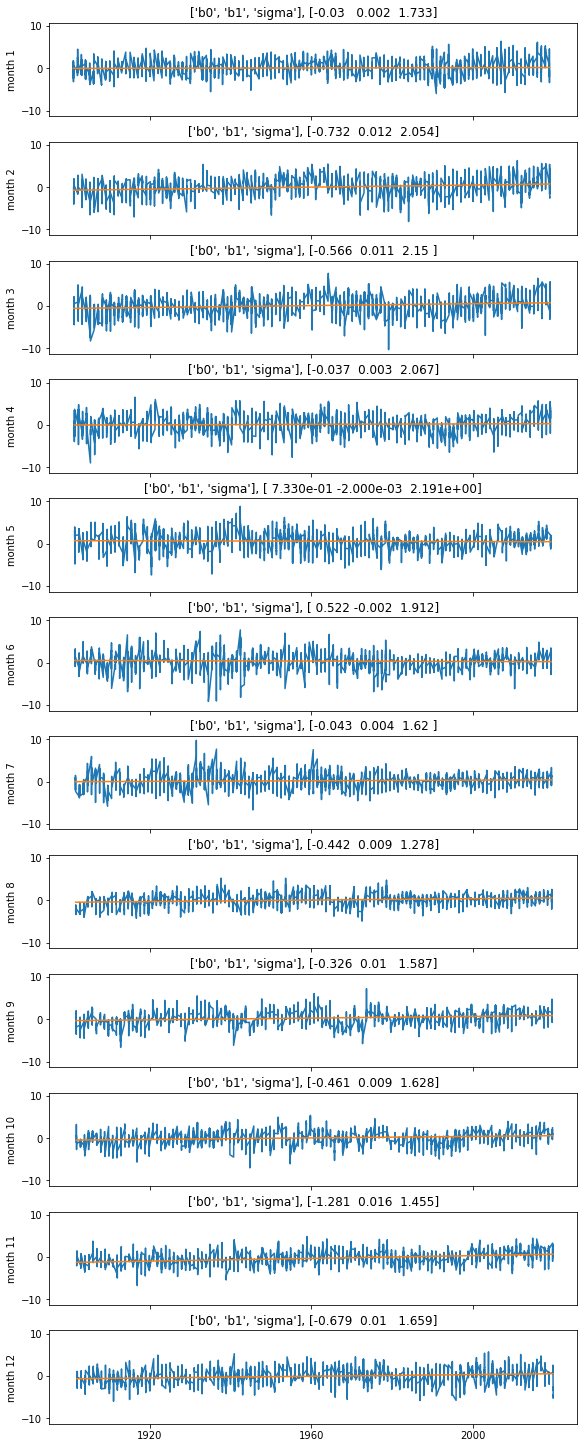

In [217]:
# monthly distribution shifting

fig, axes = plt.subplots(12,1,figsize=(8,20),layout='constrained', sharex=True, sharey=True)


# loop over months 
for j in range(1,13):
    ax=axes[j-1]
    
    da = da_delhi_deseason.sel(time=da_delhi_deseason['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year - 1900
    
    dist = dist_cov.distributions.norm_cov(data=x, cov=t)
    params_mle = dist.fit()
    predicted = dist.predict(params_mle, t)

    ax.plot(da.time, x)
    ax.plot(da.time, predicted)
    
    ax.set_title(f'{dist.param_names}, {np.round(params_mle, 3)}')
    ax.set_ylabel(f'month {j}')